# Gas Temperature from Heat Flux and Thermocouple Data
Clint Guymon. Safety Management Services, Inc. June 1, 2022

## Introduction
The gas temperature can change quickly in a reacting gas flow or in the gas flow produced from the rapid reaction of energetic materials. The use of thermocouples to measure that gas temperature can be inaccurate as that gas temperature changes rapidly. Use of heat flux gauges and/ or different sized thermocouples can be used with a energy balance model to regress or calculate the gas temperature.

Below is one way of doing so where the following steps are followed:
- First estimate the gas temperature from the heat flux data based on the following equation: $HF = \epsilon\cdot \sigma\cdot(T_{gas}^4-T_{gauge}^4) + h\cdot(T_{gas}-T_{gauge})$, where $HF$ is the measured heat flux. This equation is simply the heat flux due to convection and radiation to the heat flux gauge. Make an estimate of the heat transfer coefficient, $h$, as a function of time based on the expected gas velocity. Also make an estimate of the radiation term $\epsilon$.
- Then complete an energy balance for the thermocouple bead scenario based on the heat equation as there could be heat lost down the arms of the thermocouple wire connected to the bead: ρcp∂T∂t=∂∂r(k∂T∂r)+˙Q with ρ as density, cp as heat capacity, T as the temperature, k as the thermal conductivity, and .Q as the heat input rate. The heat equation is discretized in space to give a set of Ordinary Differential Equations (ODEs) in time.
- Using the above energy balance and the above estimated gas temperature, the thermocouple temperature can be found. That calculated thermocouple temperature can then be compared to the actual thermocouple temperature.

I realize that instead of the above steps, the measured heat flux and the temperature can be used to solve for the heat transfer coefficients and thus the gas temperature. I wanted to do that too but I ran out of time. The answers found would be similar.

## Solver details

The above equations were solved using the Gekko solver: see https://gekko.readthedocs.io/en/latest/ (Beal, L.D.R., Hill, D., Martin, R.A., and Hedengren, J. D., GEKKO Optimization Suite, Processes, Volume 6, Number 8, 2018, doi: 10.3390/pr6080106) with the Python code adapted from APMonitor (see https://apmonitor.com/do/index.php/Main/PartialDifferentialEquations). This sheet is recommended to run in a GekkoEnv (Gekko Environment in Anaconda). In other words, you'll need to install Gekko to run this sheet. See the links for installation instructions.)

In [1]:
# The parabolic PDE equation describes the evolution of temperature
#  for the interior region of the rod. This model is modified to make
#  one end of the rod fixed and the other temperature at the end of the
#  rod calculated.
import numpy as np
import pandas as pd
from gekko import GEKKO
import matplotlib.pyplot as plt

## Import temperature data
Temperature probe at Station I is next to the wall and Station J is at the center of the tunnel. All thermocouples are 36 gauge with a metal cup surrounding each one. The heat flux gauge is also at Station J.

In [2]:
data = pd.read_csv('../../../JupFiles/files/36gaugetempsm.csv', header=0)
data = data.set_index('Time')
data = data.dropna()

In [3]:
data.describe()

HF kWm2        St I2        St J2         St I         St J
count  1001.000000  1001.000000  1001.000000  1001.000000  1001.000000
mean     14.787461   143.570613   201.452277   153.519139   147.774337
std      28.118533    17.246051    43.512356    20.720468    30.788072
min      -1.375612     7.945966     7.972047     7.709273     7.963827
25%       0.907196   136.655590   172.036760   147.091720   137.624950
50%       9.965841   140.951920   207.524200   152.564410   142.523990
75%      15.497542   147.113490   223.091600   154.016620   147.263730
max     254.048542   218.704830   456.649170   267.624570   402.126560

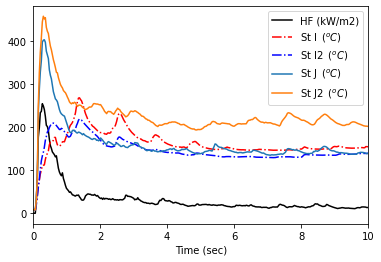

In [4]:
#data.plot() #data from testing on March 24, 2021
plt.figure()
plt.plot(data.index,data['HF kWm2'],'k-',label='HF (kW/m2)')
plt.plot(data.index,data['St I'],'r-.',label='St I $\,(^oC$)')
plt.plot(data.index,data['St I2'],'b-.',label='St I2 $\,(^oC$)')
plt.plot(data.index,data['St J'],label='St J $\,(^oC$)')
plt.plot(data.index,data['St J2'],label='St J2 $\,(^oC$)')
plt.xlabel('Time (sec)')
plt.xlim([0,10])
#plt.ylim([0,1000])
plt.legend(loc=1)
plt.show()

Notice that the thermocouple gauges at the wall measured a temperature significantly less than those in the middle of the tunnel, except for a few times after the initial 1-second interval.

## Use the heat flux data to solve for the gas temperature assuming a emissivity and heat transfer coefficient

Note that the radiation term is an estimate only as the gas absorptivity and the emissivity of the gas together with the emissivity of the heat flux gauge is all in one term.

In [5]:
#parameters
em = 0.1  #emissivity product between gas and thermocouple
vF = 1   #view Factor
hm = 800     #max heat transfer coefficient multiplier (heat transfer is a function of time as it depends on the reynolds number)
hn = 50     #min heat transfer coefficient
sbz = 5.67e-8 #stefan bolzmann constant W/m2/K4
c2k      = 273.15           # Celcius to Kelvin
Tgauge = 6 + c2k #temperature of the guage

tarr = np.array(data.index)[1:] #time
sigma = 15; mua = 0; mul = 0.49 #parameters for heat transfer coefficient 
#hc = mul*(hm-hn)/sigma/tarr*np.exp(-0.5*((np.log(tarr)-mua)/sigma)**2) + hn #convective heat transfer coefficient, W/m2/K
hc = hm/(tarr+1.3)**1.8 + hn #this is estimated based on the expected flow rate of the gases passing the heat flux gauge
mheat = np.array(data['HF kWm2'])[1:]*1000 #units of W/m2

mh = GEKKO(remote = False)

mh.time = tarr
Tg = mh.Var(Tgauge) # initial gas temperature 
theat = mh.MV()
theat.value = mheat
htc = mh.MV()
htc.value = hc

#equation to solve for each time 
mh.Equation(theat == em*vF*sbz*(Tg**4-Tgauge**4) + htc*(Tg-Tgauge))
#mh.Obj(0.35-qrad/qtot)
# simulation
mh.options.IMODE = 4
mh.solve()

 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 Current starting time value:  0.029
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  3
   Intermediates:  0
   Connections  :  0
   Equations    :  1
   Residuals    :  1
 
 Number of state variables:    999
 Number of total equations: -  999
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the E

### Gas temperature estimate

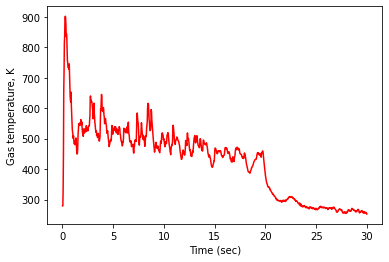

In [6]:
plt.figure()
tm = mh.time
plt.plot(tm,Tg,'r-',label='Gas temperature')
plt.ylabel('Gas temperature, K')
plt.xlabel('Time (sec)')
#plt.ylim([0,2000])
#plt.legend(loc=1)
plt.show()

### Convective heat transfer coefficient estimate

The heat transfer coefficient is highest when the gas velocity is highest. This estimate can be compared to a gas velocity calculation using the Nusselt number correlations that are functions of the Reynolds number. Modeling can be used to estimtae the gas velocity in the tunnel or it can be measured experimentally.

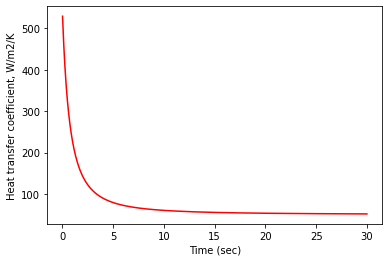

In [7]:
plt.figure()
tm = mh.time
plt.plot(tm,hc,'r-',label='Gas temperature')
plt.ylabel('Heat transfer coefficient, W/m2/K')
plt.xlabel('Time (sec)')
#plt.ylim([0,2000])a
#plt.legend(loc=1)
plt.show()

## Compare the actual to the calculated thermocouple result
Now use the gas temperature found above to get the thermocouple temperature, then compare the results to the actual temperatures measured. This approach is similar to that reported by P. Wang et al. in "Influence of surrounding gas temperature on thermocouple measurement," Case Studies in Thermal Engineering 19 (2020) 100627.

In [8]:
# Thermocouple temperature profile
seg      = 50               # number of wire segments of the thermocouple (conduction of heat down the wire)
pi       = 3.14159          # pi
dia      = 0.025/1000      #thermocouple wire diameter (m)
L        = 0.05         # wire length (m)
L_seg    = L / seg          # length of a segment (m)
bdia     = 0.075/1000       #thermocouple bead diameter (m)
bVol     = 4/3*pi*(bdia/2)**3 #bead volume
bAr      = 4*pi*(bdia/2)**2 - 0.5*pi*dia**2   #bead surface area (with area subtracted for wires)
Ar        = 2 * 0.25 * pi * dia**2     # wire (2) cross-sectional area (m)
As       = pi * dia * L_seg * 2  # surface (2) heat transfer area (m^2)
keff     = 30             # thermal conductivity in Nickel-Cr (W/m-K)
rho      = 8600             # density of Nickel-Cr (kg/m^3)
cp       = 500              # heat capacity of Nickel-Cr (J/kg-K)

vFt      = 0.1              #view factor of the thermocouple gauge (its in a cylindrical cup open at the top)
emh      = em              #estimate of the emissivity radiation factors
Tsurr    = Tgauge          #surrounding item temperatures

m = GEKKO(remote=False)  # create GEKKO model

m.time = mh.time
hconv = m.MV()
hconv.value = hc
Ts = m.MV()
Ts.value = Tg.value #the gas temperature is the surroundings temperature from the previous solution
#bfrac = m.MV()
#bfrac.value = mul*0.99/sigma/tarr*np.exp(-0.5*((np.log(tarr)-mua)/sigma)**2)

T = [m.Var(Tsurr) for i in range(seg)] # initial temperature of the segments (°C)
flag = [m.Param(1) if i<int(2) else m.Param(0) for i in range(seg)] # flag showing wheather or not the segment is exposed to the gases


# Energy balance for the rod (segments)
# accumulation =
#    (heat gained from upper segment)
#  - (heat lost to lower segment)
#  - (heat lost to surroundings)
# Units check
# kg/m^3 * m^2 * m * J/kg-K * K/sec =
#     W/m-K   * m^2 *  K / m
#  -  W/m-K   * m^2 *  K / m
#  -  W/m^2-K * m^2 *  K

#bVol = m.Intermediate(4/3*pi*((bdia/2)**3 - (bdia/2*bfrac)**3))

# first segment
m.Equation(rho*bVol*cp*T[0].dt() == \
             - keff*Ar*(T[0]-T[1])/((L_seg+bdia)/2) \
             + (hconv*(Ts-T[0]) + em*vFt*sbz*(Ts**4-T[0]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T[0]**4))*bAr*flag[0])  
#second segment
m.Equation(rho*Ar*L_seg*cp*T[1].dt() == \
             keff*Ar*(T[0]-T[1])/((L_seg+bdia)/2) \
           - keff*Ar*(T[1]-T[2])/L_seg \
             + (hconv*(Ts-T[1]) + em*vFt*sbz*(Ts**4-T[1]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T[1]**4))*As*flag[1])  
# middle segments
m.Equations([rho*Ar*L_seg*cp*T[i].dt() == \
               keff*Ar*(T[i-1]-T[i])/L_seg \
             - keff*Ar*(T[i]-T[i+1])/L_seg \
             + (hconv*(Ts-T[i]) + em*vFt*sbz*(Ts**4-T[i]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T[i]**4))*As*flag[i] for i in range(2,seg-1)])
# last segment
m.Equation(rho*Ar*L_seg*cp*T[seg-1].dt() == \
             keff*Ar*(T[seg-2]-T[seg-1])/L_seg \
            - keff*Ar*(T[seg-1]-Tsurr)/L_seg )

# simulation
m.options.IMODE = 7
m.solve()

 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 Current starting time value:  0.029
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  102
   Intermediates:  0
   Connections  :  0
   Equations    :  50
   Residuals    :  50
 
 Number of state variables:    100
 Number of total equations: -  100
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Sequential Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code unde

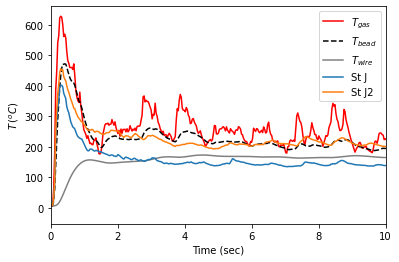

In [9]:
# plot results
plt.figure()
tm = m.time
plt.plot(tm,np.array(Ts.value)-c2k,'r-',label=r'$T_{gas}$')
plt.plot(tm,(np.array(T[0].value)-c2k),'k--',label=r'$T_{bead}$')
plt.plot(tm,(np.array(T[4].value)-c2k),'gray',label=r'$T_{wire}$')
plt.plot(data.index,data['St J'],label='St J')
plt.plot(data.index,data['St J2'],label='St J2')
plt.ylabel(r'$T\,(^oC$)')
plt.xlabel('Time (sec)')
plt.xlim([0,10])
plt.legend(loc=1)
plt.show()

From the above plot, the calculated bead temperature (black dashed line) is similar to the station gauge temperatures indicating the estimated gas temperature and heat flux coefficients are close to the actual values.  The gas temperature is sometimes 100 to 200 degrees above the thermocouple temperature and at other times equal to the thermocouple temperature.

Note also that the heat flux gauge is also much more responsive than the thermocouple gauge.

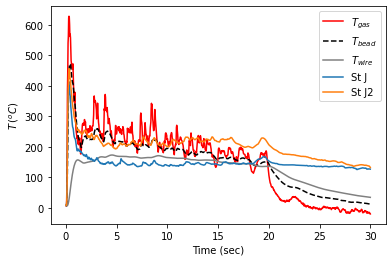

In [10]:
# plot results with a longer time frame
plt.figure()
tm = m.time
plt.plot(tm,np.array(Ts.value)-c2k,'r-',label=r'$T_{gas}$')
plt.plot(tm,(np.array(T[0].value)-c2k),'k--',label=r'$T_{bead}$')
plt.plot(tm,(np.array(T[4].value)-c2k),'gray',label=r'$T_{wire}$')
plt.plot(data.index,data['St J'],label='St J')
plt.plot(data.index,data['St J2'],label='St J2')
plt.ylabel(r'$T\,(^oC$)')
plt.xlabel('Time (sec)')
plt.legend(loc=1)
plt.show()

Note that at long times (>10 seconds), the calculated bead temperature does not agree with the measured temperature as the effect of the heated dust present near the thermocouple is not accounted for in the model. However, the gas temperature (predicted from the heat flux measured) does show a decay.

## Conduction, Convection, and Radiation Amounts

In [11]:
Tbead = np.array(T[0].value)
Twire4 = np.array(T[4].value)
Tgas = Ts.value
Cond = keff*(Twire4-Tbead)/((L_seg+bdia)/2+3*L_seg)*Ar #W
Conv = np.array(hconv)*(Tgas-Tbead)*bAr
Rad = [(em*vFt*sbz*(Tgas[i]**4-Tbead[i]**4) + emh*(1-vFt)*sbz*(Tsurr**4-Tbead[i]**4))*bAr for i,each in enumerate(Tgas)]
Tot = Cond+Conv+Rad+1e-12
fc = Cond/Tot; fv = Conv/Tot; fr = Rad/Tot

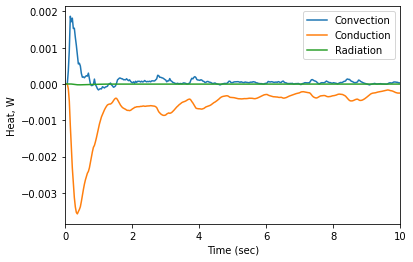

In [12]:
# plot results with a longer time frame
plt.figure()
tm = m.time
plt.plot(tm,Conv,label='Convection')
plt.plot(tm,Cond,label='Conduction')
plt.plot(tm,Rad,label='Radiation')
plt.ylabel('Heat, W')
plt.xlabel('Time (sec)')
plt.xlim([0,10])
plt.legend(loc=1)
plt.show()

From the above plot, it appears that radiation is not a large factor but the conduction down the length of the thermocouple wire should be included.

### Benefits of 30 gauge thermocouple in addition to 36 gauge 

If a 30 gauge thermocouple is also at the same location as the 36 gauge thermocouple, the different sizes can be used to also benchmark the gas temperature estimate in a similar way as was done with the heat flux gauge. Plotted below are a 36 gauge and 30 gauge thermocouple profiles given the above results. 

In [13]:
# Thermocouple temperature profile
seg      = 50               # number of wire segments of the thermocouple (conduction of heat down the wire)
pi       = 3.14159          # pi
dia      = 0.125/1000      #thermocouple wire diameter (m)
L        = 0.05         # wire length (m)
L_seg    = L / seg          # length of a segment (m)
bdia     = 0.375/1000       #thermocouple bead diameter (m)
bVol     = 4/3*pi*(bdia/2)**3 #bead volume
bAr      = 4*pi*(bdia/2)**2 - 0.5*pi*dia**2   #bead surface area (with area subtracted for wires)
Ar        = 2 * 0.25 * pi * dia**2     # wire (2) cross-sectional area (m)
As       = pi * dia * L_seg * 2  # surface (2) heat transfer area (m^2)
keff     = 30             # thermal conductivity in Nickel-Cr (W/m-K)
rho      = 8600             # density of Nickel-Cr (kg/m^3)
cp       = 500              # heat capacity of Nickel-Cr (J/kg-K)

vFt      = 0.1              #view factor of the thermocouple gauge (its in a cylindrical cup open at the top)
emh      = em              #estimate of the emissivity radiation factors
Tsurr    = Tgauge          #surrounding item temperatures

m = GEKKO(remote=False)  # create GEKKO model

m.time = mh.time
hconv = m.MV()
hconv.value = hc
Ts = m.MV()
Ts.value = Tg.value #the gas temperature is the surroundings temperature from the previous solution
#bfrac = m.MV()
#bfrac.value = mul*0.99/sigma/tarr*np.exp(-0.5*((np.log(tarr)-mua)/sigma)**2)

T3g = [m.Var(Tsurr) for i in range(seg)] # initial temperature of the segments (°C)
flag = [m.Param(1) if i<int(2) else m.Param(0) for i in range(seg)] # flag showing wheather or not the segment is exposed to the gases


# Energy balance for the rod (segments)
# accumulation =
#    (heat gained from upper segment)
#  - (heat lost to lower segment)
#  - (heat lost to surroundings)
# Units check
# kg/m^3 * m^2 * m * J/kg-K * K/sec =
#     W/m-K   * m^2 *  K / m
#  -  W/m-K   * m^2 *  K / m
#  -  W/m^2-K * m^2 *  K

#bVol = m.Intermediate(4/3*pi*((bdia/2)**3 - (bdia/2*bfrac)**3))

# first segment
m.Equation(rho*bVol*cp*T3g[0].dt() == \
             - keff*Ar*(T3g[0]-T3g[1])/((L_seg+bdia)/2) \
             + (hconv*(Ts-T3g[0]) + em*vFt*sbz*(Ts**4-T3g[0]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T3g[0]**4))*bAr*flag[0])  
#second segment
m.Equation(rho*Ar*L_seg*cp*T3g[1].dt() == \
             keff*Ar*(T3g[0]-T3g[1])/((L_seg+bdia)/2) \
           - keff*Ar*(T3g[1]-T3g[2])/L_seg \
             + (hconv*(Ts-T3g[1]) + em*vFt*sbz*(Ts**4-T3g[1]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T3g[1]**4))*As*flag[1])  
# middle segments
m.Equations([rho*Ar*L_seg*cp*T3g[i].dt() == \
               keff*Ar*(T3g[i-1]-T3g[i])/L_seg \
             - keff*Ar*(T3g[i]-T3g[i+1])/L_seg \
             + (hconv*(Ts-T3g[i]) + em*vFt*sbz*(Ts**4-T3g[i]**4) + emh*(1-vFt)*sbz*(Tsurr**4-T3g[i]**4))*As*flag[i] for i in range(2,seg-1)])
# last segment
m.Equation(rho*Ar*L_seg*cp*T3g[seg-1].dt() == \
             keff*Ar*(T3g[seg-2]-T3g[seg-1])/L_seg \
            - keff*Ar*(T3g[seg-1]-Tsurr)/L_seg )

# simulation
m.options.IMODE = 7
m.solve()

 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 Current starting time value:  0.029
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  102
   Intermediates:  0
   Connections  :  0
   Equations    :  50
   Residuals    :  50
 
 Number of state variables:    100
 Number of total equations: -  100
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Sequential Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code unde

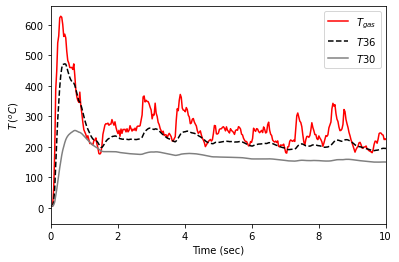

In [14]:
# plot results
plt.figure()
tm = m.time
plt.plot(tm,np.array(Ts.value)-c2k,'r-',label=r'$T_{gas}$')
plt.plot(tm,(np.array(T[0].value)-c2k),'k--',label=r'$T36$')
plt.plot(tm,(np.array(T3g[0].value)-c2k),'gray',label=r'$T30$')
plt.ylabel(r'$T\,(^oC$)')
plt.xlabel('Time (sec)')
plt.xlim([0,10])
plt.legend(loc=1)
plt.show()

## Gas Temperature from Thermocouple Temperature

Although not done here, a model could be written to calculate the gas temperature from the thermocouple data. Having data for both 36 and 30 gauge thermocouples at the same position would be helpful in doing so. 